In [1]:
import pandas as pd
import numpy as np
import functools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# simple conditional diffusion

Now we fit a conditional distribution on a simple distribution: $p(x|r)\sim Uni(r\cdot S_d)$, i.e, uniform distribution of a $d$-dimension circle with radius $r$.

# prepare dataset

In [2]:
# read data
sample_size = 10000
r = np.random.rand(sample_size) * 2 + 1 # r\in [1,3]
X = np.random.randn(sample_size, 2) # 2 dimension data
X = r.reshape(sample_size,-1) * X / np.linalg.norm(X,axis=1).reshape(sample_size,-1) 

X_tensor = torch.FloatTensor(X)
r_tensor = torch.FloatTensor(r).reshape(-1,1)

# Define the diffusion model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def index_iterator(device, data_len, batchsize = 32):
    perm_idx = np.random.permutation(data_len)
    num_steps = (data_len // batchsize) if (data_len % batchsize) == 0 else (data_len // batchsize) + 1
    for ii in range(num_steps):
        if ii < (num_steps - 1):
            batch_idx = perm_idx[(ii*batchsize):(ii*batchsize+batchsize)]
        else:
            batch_idx = perm_idx[(ii*batchsize):]
        
        yield batch_idx

class Diffusion_SDE(nn.Module):
    def __init__(self, input_dim, cond_dim, time_emb_dim = 32, eps=1e-5, sigma = 100, scale = 9,block_layer =1, device=None):
        super(Diffusion_SDE, self).__init__()
        self.device = device
        self.marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
        self.diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
        self.eps = eps
        self.score_model = UNet_MLP(input_dim, cond_dim, self.marginal_prob_std_fn, time_emb_dim = time_emb_dim, scale = scale, block_layer = block_layer).to(device)
        self.input_dim = input_dim

    def forward(self, x0, cond):
        random_t = torch.rand(x0.shape[0], device=self.device) * (1. - self.eps) + self.eps 
        z = torch.randn_like(x0)
        std = self.marginal_prob_std_fn(random_t)
        perturbed_x = x0 + z * std[:, None]
        score = self.score_model(perturbed_x, cond, random_t) * std[:, None]
        loss = torch.mean(torch.sum((score  + z)**2, dim=1))
        
        return loss
    
    def em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        return mean_x

    def deterministic_em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                x = mean_x
        return mean_x

    def nonnegative_em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                mean_x.clamp_(min=1)
                x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)

        return mean_x
                
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out


def marginal_prob_std(t, sigma):
    #t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return sigma**t
  

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, marginal_prob_std, time_emb_dim=32, scale = 4, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))

        
        self.marginal_prob_std = marginal_prob_std
        
        self.input_dim = input_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_dim, second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, xc, ti):
        
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)

        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out / self.marginal_prob_std(ti)[:, None]

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# train the diffusion score model

In [19]:
diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)

# training 
batchsize = 128
epoch = 100
lr = 5e-4
optimizer = Adam(diffusion_process.parameters(), lr)
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(X_tensor), batchsize = 32):
        optimizer.zero_grad()
        steps +=1 
        x0 = X_tensor[batch_index].cuda()
        xc = r_tensor[batch_index].cuda()
        loss = diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    if ep % 100 == 0:     
        torch.save(diffusion_process.state_dict(), "base_model.pkl")
        print("save model")
torch.save(diffusion_process.state_dict(), "base_model.pkl")
print("save model")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:03<05:03,  3.07s/it, avg_loss=0.898]

save model


100%|██████████| 100/100 [04:54<00:00,  2.95s/it, avg_loss=0.551]

save model


# load previous weight

In [23]:
diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)
diffusion_process.load_state_dict(torch.load('base_model.pkl'))

<All keys matched successfully>

# sample from the diffusion model

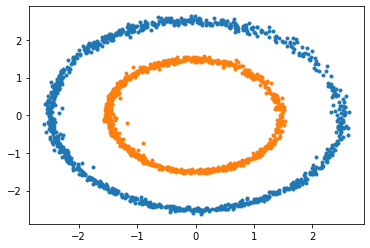

In [21]:
# generate the circle with radius 2.5
x_gen1 = diffusion_process.em_sampler(torch.ones((1000,1)).cuda()+1.5)
x_gen1 = x_gen1.cpu()

# generate the circle with radius 1.5
x_gen2 = diffusion_process.em_sampler(torch.ones((1000,1)).cuda()+0.5)
x_gen2 = x_gen2.cpu()

plt.plot(x_gen1[:,0],x_gen1[:,1],".")
plt.plot(x_gen2[:,0],x_gen2[:,1],".")
plt.show()

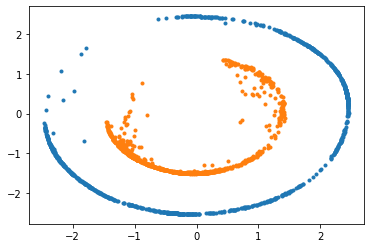

In [7]:
x_gen1 = diffusion_process.deterministic_em_sampler(torch.ones((1000,1)).cuda()+1.5)
x_gen1 = x_gen1.cpu()

# generate the circle with radius 1.5
x_gen2 = diffusion_process.deterministic_em_sampler(torch.ones((1000,1)).cuda()+0.5)
x_gen2 = x_gen2.cpu()

plt.plot(x_gen1[:,0],x_gen1[:,1],".")
plt.plot(x_gen2[:,0],x_gen2[:,1],".")
plt.show()

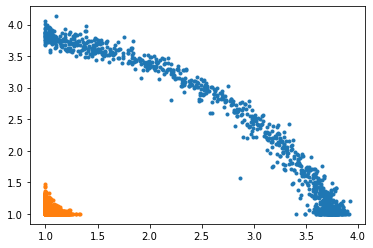

In [24]:
x_gen1 = diffusion_process.nonnegative_em_sampler(torch.ones((1000,1)).cuda()+3)
x_gen1 = x_gen1.cpu()

# generate the circle with radius 1.5
x_gen2 = diffusion_process.nonnegative_em_sampler(torch.ones((1000,1)).cuda()+0.5)
x_gen2 = x_gen2.cpu()

plt.plot(x_gen1[:,0],x_gen1[:,1],".")
plt.plot(x_gen2[:,0],x_gen2[:,1],".")
plt.show()